__This notebook is an initial attempt to do a deep learning model using AWS Sagemaker.__

__This notebook follows the sample notebook in AWS Sagemaker.__

## Prequisites and Preprocessing

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are two parts to this:

1. The role(s) used to give learning and hosting access to your data. Here we extract the role you created earlier for accessing your notebook.  See the documentation if you want to specify  a different role
1. The S3 bucket name and locations that you want to use for training and model data.

In [1]:
from sagemaker import get_execution_role

role = get_execution_role()
bucket='BAX452-HW8'

### Data ingestion

Next, we read the dataset from the existing repository into memory, for preprocessing prior to training.  In this case we'll use the MNIST dataset, which contains 70K 28 x 28 pixel images of handwritten digits.  For more details, please see [here](http://yann.lecun.com/exdb/mnist/).

This processing could be done *in situ* by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present in the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. For small datasets, such as this one, reading into memory isn't onerous, though it would be for larger datasets.

In [2]:
%%time
import pickle, gzip, numpy, urllib.request, json

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 868 ms, sys: 332 ms, total: 1.2 s
Wall time: 1.74 s


### Data inspection

Once the dataset is imported, it's typical as part of the machine learning process to inspect the data, understand the distributions, and determine what type(s) of preprocessing might be needed. You can perform those tasks right here in the notebook. As an example, let's go ahead and look at one of the digits that is part of the dataset.

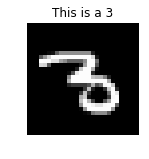

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

## Training the K-Means model

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. Since this data is relatively small, it isn't meant to show off the performance of the k-means training algorithm.  But Amazon SageMaker's k-means has been tested on, and scales well with, multi-terabyte datasets.

After setting training parameters, we kick off training, and poll for status until training is completed, which in this example, takes between 7 and 11 minutes.

In [4]:
from sagemaker import KMeans

data_location = 's3://sagemaker-mlhw8/input'.format(bucket)
output_location = 's3://sagemaker-mlhw8/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = KMeans(role=role,
                train_instance_count=2,
                train_instance_type='ml.c4.8xlarge',
                output_path=output_location,
                k=10,
                data_location=data_location)

training data will be uploaded to: s3://sagemaker-mlhw8/input
training artifacts will be uploaded to: s3://sagemaker-mlhw8/output


INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-839136978653


In [5]:
%%time

kmeans.fit(kmeans.record_set(train_set[0]))

INFO:sagemaker:Creating training-job with name: kmeans-2018-03-10-04-15-00-153


.....................................................................
Docker entrypoint called with argument(s): train
[03/10/2018 04:20:40 INFO 140014036404032] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'half_life_time_size': u'0', u'_num_slices': u'1'}
[03/10/2018 04:20:40 INFO 140014036404032] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'784', u'mini_batch_size': u'500', u'k': u'10', u'force_dense': u'True'}
[03/10/2018 04:20:40 INFO 140014036

===== Job Complete =====
CPU times: user 7.96 s, sys: 384 ms, total: 8.34 s
Wall time: 7min 51s


## Set up hosting for the model
Now, we can deploy the model we just trained behind a real-time hosted endpoint.  This next step can take, on average, 7 to 11 minutes to complete.

In [6]:
%%time

kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: kmeans-2018-03-10-04-22-41-257
INFO:sagemaker:Creating endpoint with name kmeans-2018-03-10-04-15-00-153


---------------------------------------------------------------------------------------------------!CPU times: user 392 ms, sys: 36 ms, total: 428 ms
Wall time: 8min 28s


## Validate the model for use
Finally, we'll validate the model for use. Let's generate a classification for a single observation from the trained model using the endpoint we just created.

In [7]:
result = kmeans_predictor.predict(train_set[0][30:31])
print(result)

[label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 2.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 7.3603057861328125
    }
  }
}
]


Let's do a whole batch and see how well the clustering works.

In [8]:
%%time 

result = kmeans_predictor.predict(valid_set[0][0:100])
clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 310 ms





Cluster 0:


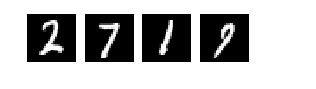




Cluster 1:


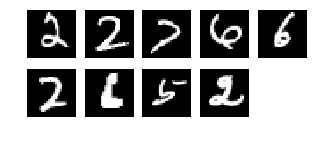




Cluster 2:


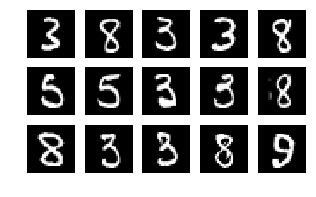




Cluster 3:


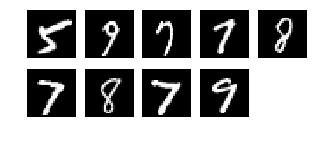




Cluster 4:


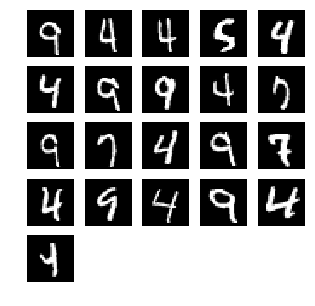




Cluster 5:


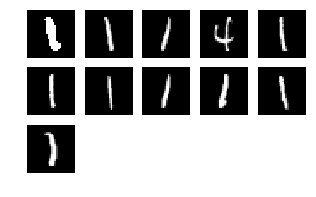




Cluster 6:


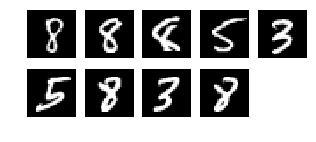




Cluster 7:


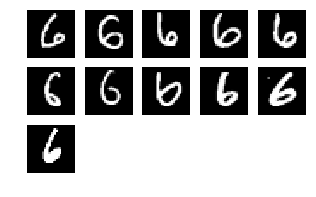




Cluster 8:


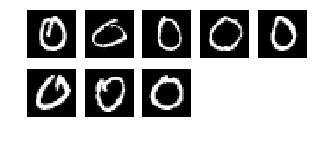




Cluster 9:


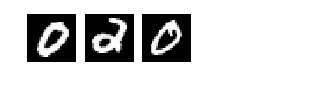

In [9]:
for cluster in range(10):
    print('\n\n\nCluster {}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster ]
    height=((len(digits)-1)//5)+1
    width=5
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots=numpy.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')

    plt.show()

### The bottom line

K-Means clustering is not the best algorithm for image analysis problems, but we do see pretty reasonable clusters being built.